In [206]:
import pandas as pd
import numpy as np  
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import cross_val_score


In [207]:
df = pd.read_excel('premiums.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [208]:
df.shape

(50000, 13)

In [209]:
df.columns=df.columns.str.replace(' ', '_').str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

In [210]:
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053


### Handle NA Values

In [211]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [212]:
df.dropna(inplace=True)

In [213]:
df.isna().sum()
df.shape

(49976, 13)

In [214]:
df.duplicated().sum()

0

In [215]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,49976.0,34.591764,15.000378,18.0,22.00,31.0,45.0,356.0
number_of_dependants,49976.0,1.711842,1.498195,-3.0,0.00,2.0,3.0,5.0
income_lakhs,49976.0,23.021150,24.221794,1.0,7.00,17.0,31.0,930.0
annual_premium_amount,49976.0,15766.810189,8419.995271,3501.0,8607.75,13928.0,22273.5,43471.0


In [216]:
df[df.number_of_dependants<0]["number_of_dependants"].unique()

array([-3, -1], dtype=int64)

In [217]:
df["number_of_dependants"]=abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [218]:
numeric_col=df.columns[df.dtypes!="object"].to_list()
numeric_col

['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount']

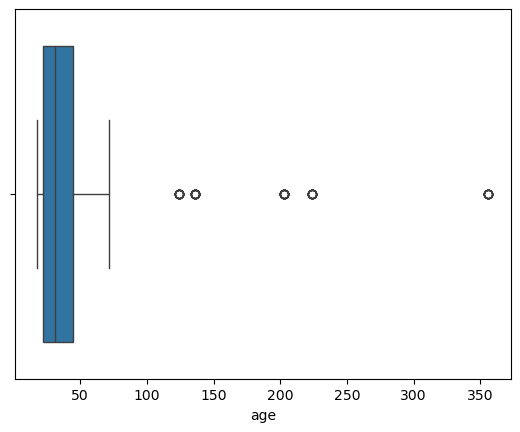

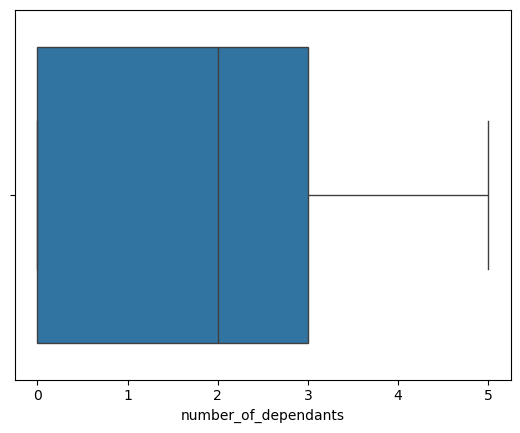

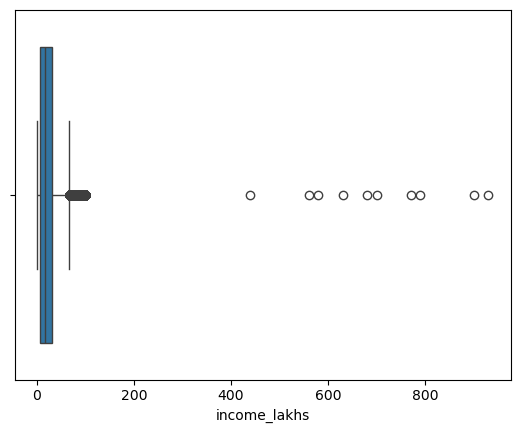

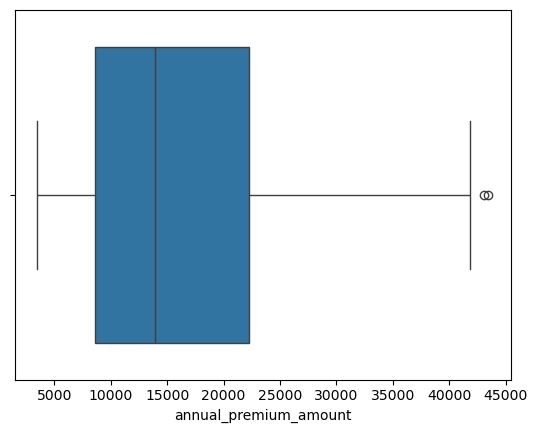

In [219]:
for col in numeric_col:
    sns.boxplot(x=df[col])
    plt.show()

In [220]:
df[df.age>100]["age"].unique()


array([224, 124, 136, 203, 356], dtype=int64)

In [221]:
df1=df[df.age<=100].copy()
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
age,49918.0,34.401839,13.681600,18.0,22.0,31.0,45.0,72.0
number_of_dependants,49918.0,1.717617,1.492074,0.0,0.0,2.0,3.0,5.0
income_lakhs,49918.0,23.025141,24.227912,1.0,7.0,17.0,31.0,930.0
annual_premium_amount,49918.0,15766.589286,8419.137327,3501.0,8608.0,13928.0,22272.0,43471.0


In [222]:
def get_iqr_bounce(col):
    Q1,Q3=col.quantile([0.25,0.75])
    IQR=Q3-Q1
    lower_bounce=Q1-1.5*IQR
    upper_bounce=Q3+1.5*IQR
    return lower_bounce, upper_bounce

In [223]:
get_iqr_bounce(df1["income_lakhs"])

(-29.0, 67.0)

In [224]:
Quantile_threshold=df1.income_lakhs.quantile(0.999)
Quantile_threshold

100.0

In [225]:
df2=df1[df1.income_lakhs<=Quantile_threshold].copy()
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
age,49908.0,34.401579,13.681604,18.0,22.0,31.0,45.0,72.0
number_of_dependants,49908.0,1.717640,1.492032,0.0,0.0,2.0,3.0,5.0
income_lakhs,49908.0,22.889897,22.170699,1.0,7.0,17.0,31.0,100.0
annual_premium_amount,49908.0,15765.739641,8418.674061,3501.0,8608.0,13928.0,22270.5,43471.0


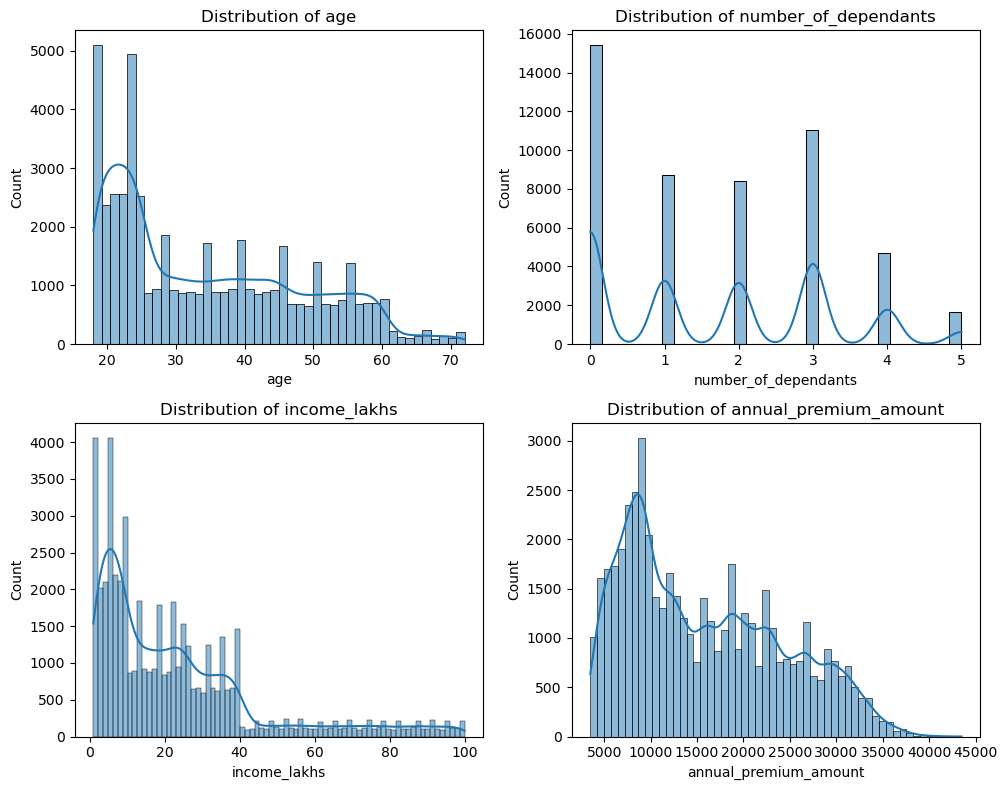

In [226]:
fig,axs=plt.subplots(nrows=2,ncols=2,figsize=(10,8))
for i,col in enumerate(numeric_col):
    ax=axs[i//2,i%2]
    sns.histplot(df2[col], kde=True,ax=ax)
    ax.set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

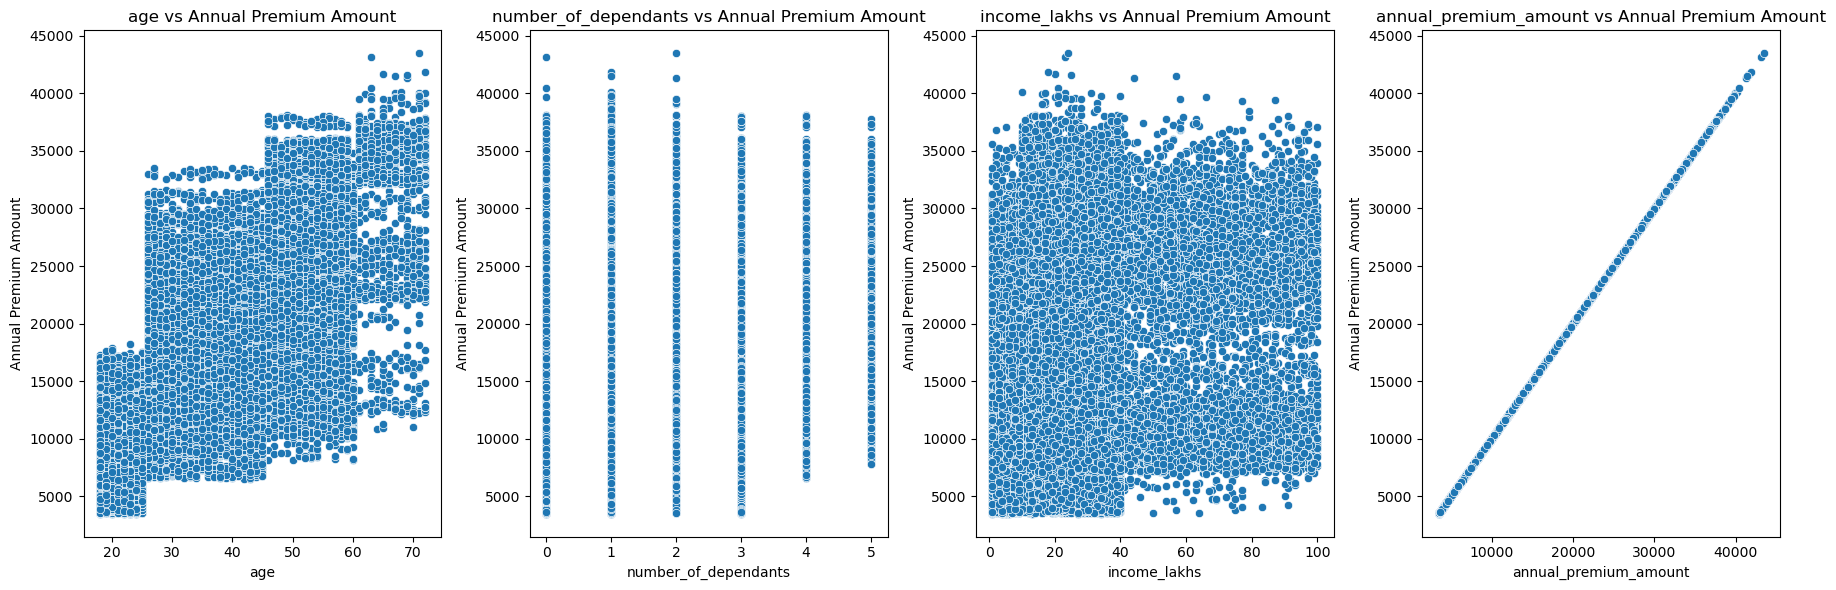

In [227]:
fig,axs=plt.subplots(1,4,figsize=(18,6))
for ax,col in zip(axs,numeric_col):
    
    sns.scatterplot(x=df2[col], y=df2["annual_premium_amount"],ax=ax)
    ax.set_title(f'{col} vs Annual Premium Amount')
    ax.set_xlabel(col)
    ax.set_ylabel("Annual Premium Amount")
plt.tight_layout()
plt.show()

In [228]:
categorical_col=df2.columns[df2.dtypes=="object"].to_list()
categorical_col

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'medical_history',
 'insurance_plan']

In [229]:
for col in categorical_col:
    print(col,":",df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [230]:
df2["smoking_status"].replace({"Smoking=0":"No Smoking","Does Not Smoke":"No Smoking","Not Smoking":"No Smoking"},inplace=True)

C:\Users\Satya\AppData\Local\Temp\ipykernel_18744\2345664793.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["smoking_status"].replace({"Smoking=0":"No Smoking","Does Not Smoke":"No Smoking","Not Smoking":"No Smoking"},inplace=True)


In [231]:
df2.smoking_status.unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [232]:
pct_count_gender=df2["gender"].value_counts(normalize=True)

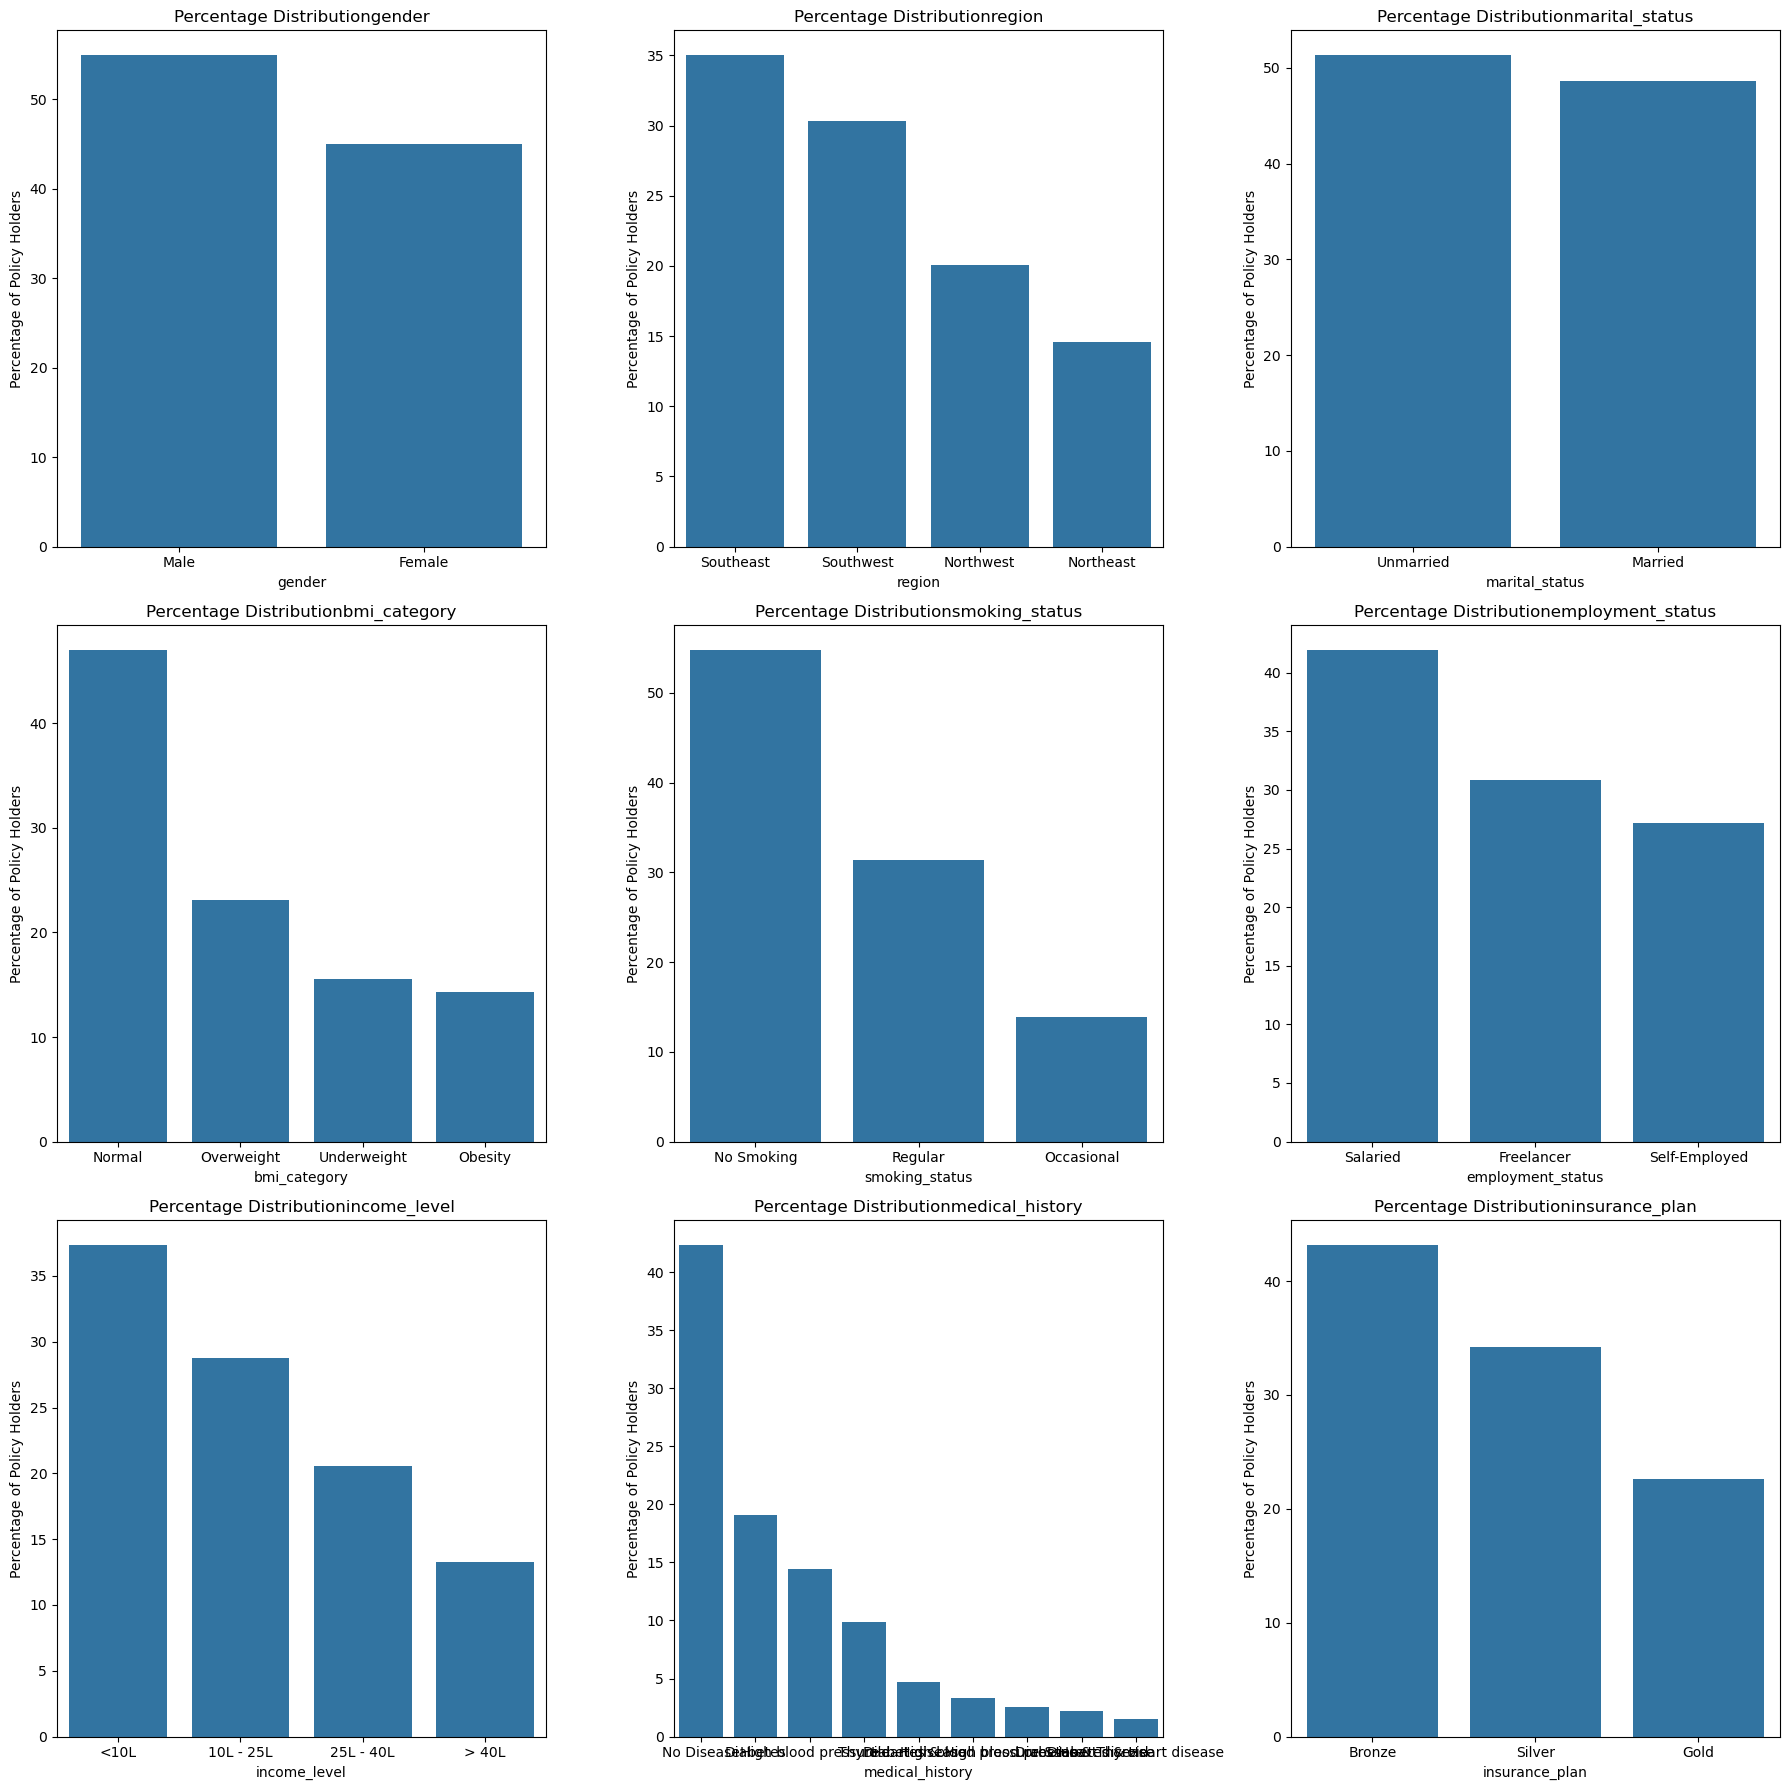

In [233]:
fig,axs=plt.subplots(3,3,figsize=(18,18))
axs = axs.flatten()
for ax,col in zip(axs,categorical_col):
    category_counts=df2[col].value_counts(normalize=True)*100
    
    sns.barplot(x=category_counts.index,y=category_counts.values,ax=ax)
    ax.set_title(f'Percentage Distribution{col}')
    ax.set_xlabel(col)
    ax.set_ylabel("Percentage of Policy Holders")
plt.tight_layout()
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


Text(0.5, 1.0, 'Income Level vs Insurance Plan')

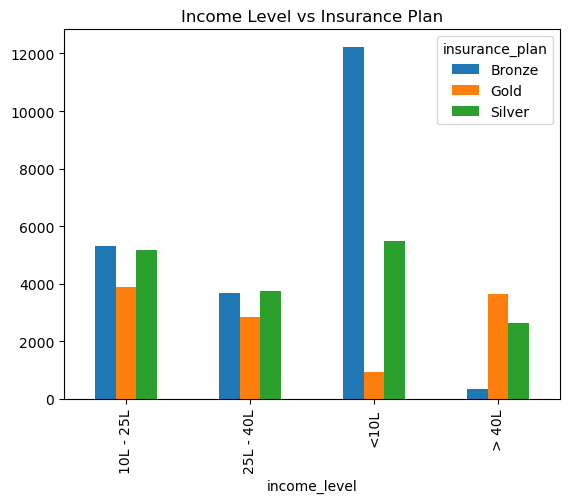

In [234]:
cross_tab=pd.crosstab(df2["income_level"],df2["insurance_plan"])
print(cross_tab)
cross_tab.plot(kind="bar")
plt.title("Income Level vs Insurance Plan")

In [235]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [236]:
# risk_score={"Diabetes":6,"Heart disease":8,"High blood pressure":6,"Thyroid":5,"No Disease":0,"None":0}
# df2[["disease1","disease2"]]=df2.medical_history.str.split("&",expand=True)
# df2.head(15)

In [237]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(15)

C:\Users\Satya\AppData\Local\Temp\ipykernel_18744\2503336130.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none', inplace=True)
C:\Users\Satya\AppData\Local\Temp\ipykernel_18744\2503336130.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
5,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,diabetes,none,6,0.428571
6,33,Male,Southeast,Married,3,Normal,Regular,Self-Employed,<10L,4,Diabetes & High blood pressure,Silver,20653,diabetes,high blood pressure,12,0.857143
7,43,Male,Northeast,Married,3,Overweight,Regular,Salaried,> 40L,46,Thyroid,Gold,26926,thyroid,none,5,0.357143
8,59,Female,Southeast,Unmarried,0,Overweight,No Smoking,Freelancer,10L - 25L,21,No Disease,Gold,26101,no disease,none,0,0.000000
9,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000


### Yha se krna hai

In [238]:
# df2["disease1"].fillna("None",inplace=True)
# df2["disease2"].fillna("None",inplace=True)
# df2["Total_risk_score"]=0
# for disease in ["disease1","disease2"]:
#     df2["Total_risk_score"]+=df2[disease].map(risk_score)
# max_score=df2["Total_risk_score"].max()
# min_score=df2["Total_risk_score"].min()
# df2["normalized_risk_score"]=(df2["Total_risk_score"]-min_score)/(max_score-min_score)
# df2.head(15)

In [239]:
# max_score

In [240]:
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [241]:
df2["insurance_plan"]=df2["insurance_plan"].map({"Bronze":1,"Silver":2,"Gold":3})


In [242]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,3,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571


In [243]:
df2.insurance_plan.unique()

array([1, 2, 3], dtype=int64)

In [244]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [245]:
df2["income_level"]=df2["income_level"].map({"<10L":1,"10L - 25L":2,"> 40L":4,"25L - 40L":3})
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571


In [246]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1


In [247]:
df4=df3.drop(["medical_history","disease1","disease2","total_risk_score"],axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


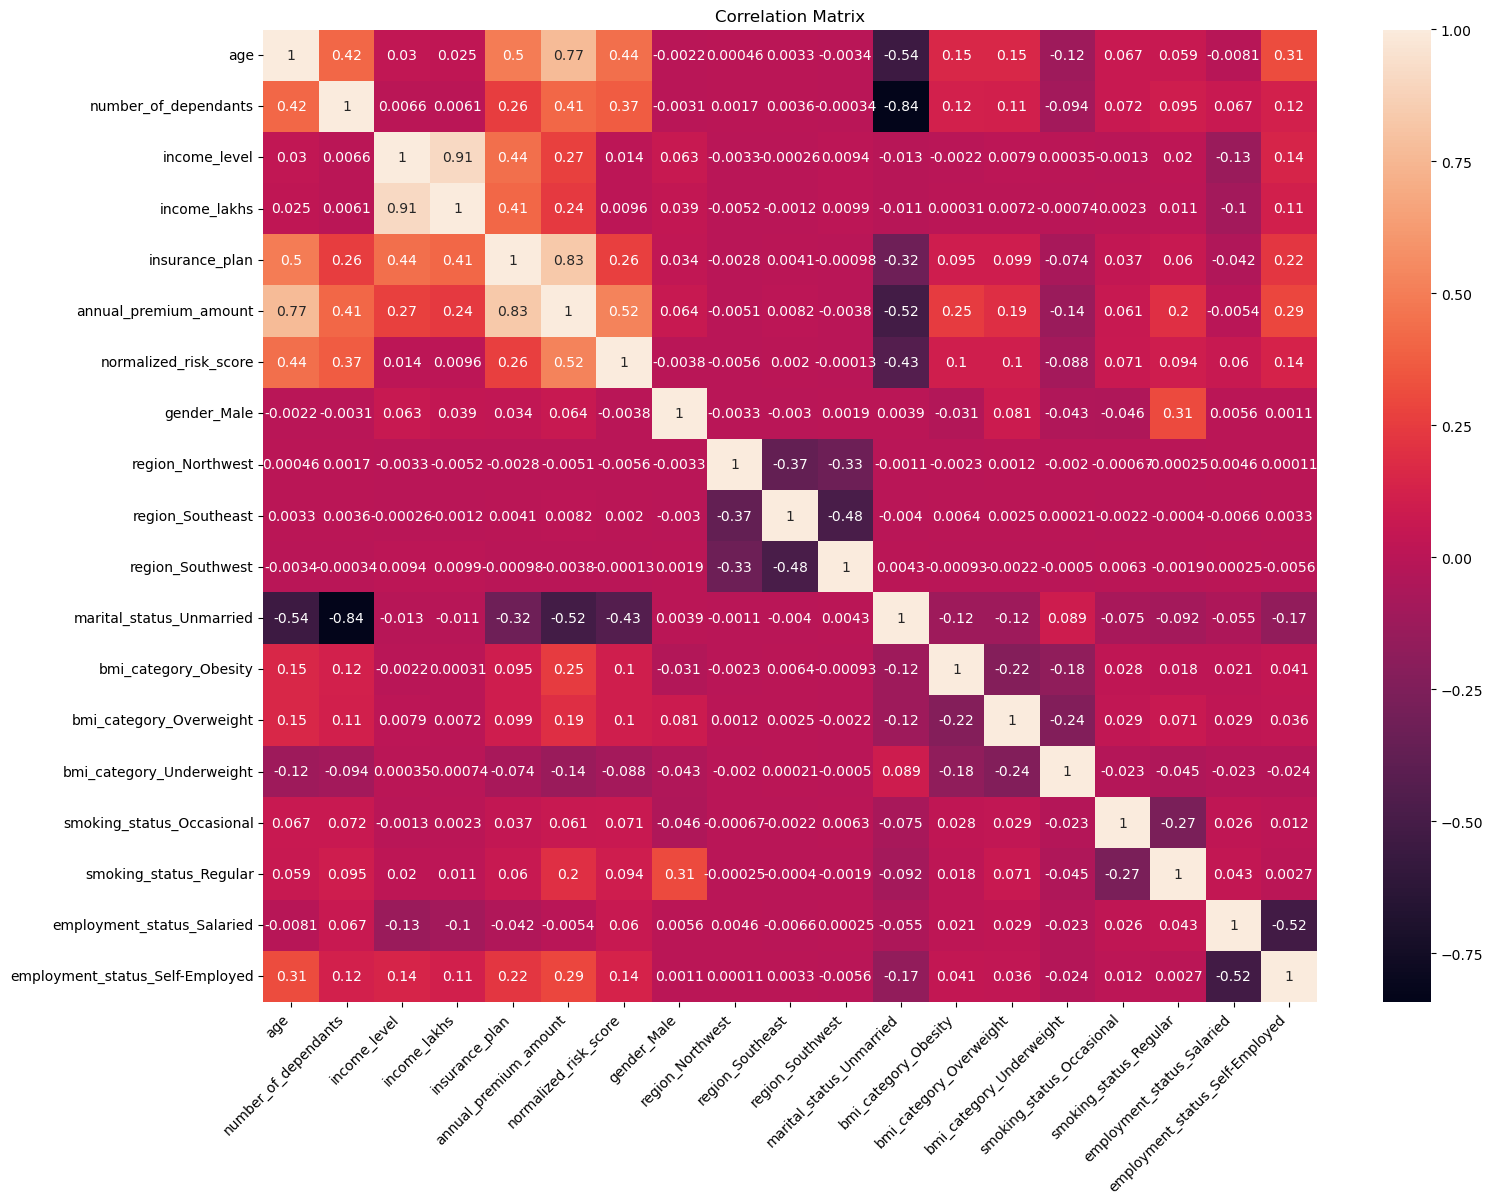

In [249]:
cm=df4.corr()
plt.figure(figsize=(16,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.title("Correlation Matrix") 

plt.show()

In [250]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


In [252]:
X=df4.drop("annual_premium_amount",axis="columns")
y=df4["annual_premium_amount"]
from sklearn.preprocessing import MinMaxScaler
cols_to_scale=["age","number_of_dependants","income_level","income_lakhs","insurance_plan"]
scaler=MinMaxScaler()
X[cols_to_scale]=scaler.fit_transform(X[cols_to_scale])
X.head(2)
X.describe()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.365900,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.349711,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [268]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [269]:
calculate_vif(X)

,Column,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


In [270]:
calculate_vif(X.drop('income_level', axis="columns"))

,Column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [271]:
X_reduced=X.drop('income_level', axis="columns")
X_reduced.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


### Model Training

In [321]:
x_train,x_test,y_train,y_test=train_test_split(X_reduced, y, test_size=0.3, random_state=10)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(34935, 17) (14973, 17) (34935,) (14973,)


In [322]:
Lr=LinearRegression()
Lr.fit(x_train,y_train)
test_score=Lr.score(x_test,y_test)
train_score=Lr.score(x_train,y_train)
print("Test Score:",test_score)
print("Train Score:",train_score)

Test Score: 0.9280547230217837
Train Score: 0.928214357691676


In [323]:
x_test.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
3598,0.481481,0.4,0.343434,0.5,0.428571,1,0,1,0,1,0,1,0,0,1,1,0
35794,0.648148,0.6,0.202020,1.0,0.000000,1,0,0,0,0,1,0,0,1,0,1,0


In [324]:
Lr.coef_

array([11160.92646188,  -676.44399066,  -514.22981577, 12557.01293645,
        4810.35770228,   168.64666183,   -35.7192924 ,    39.96512973,
         -24.65292857,  -935.76061134,  3387.91145477,  1599.36226775,
         391.1713038 ,   735.91227798,  2234.8047119 ,   155.9846743 ,
         415.90397305])

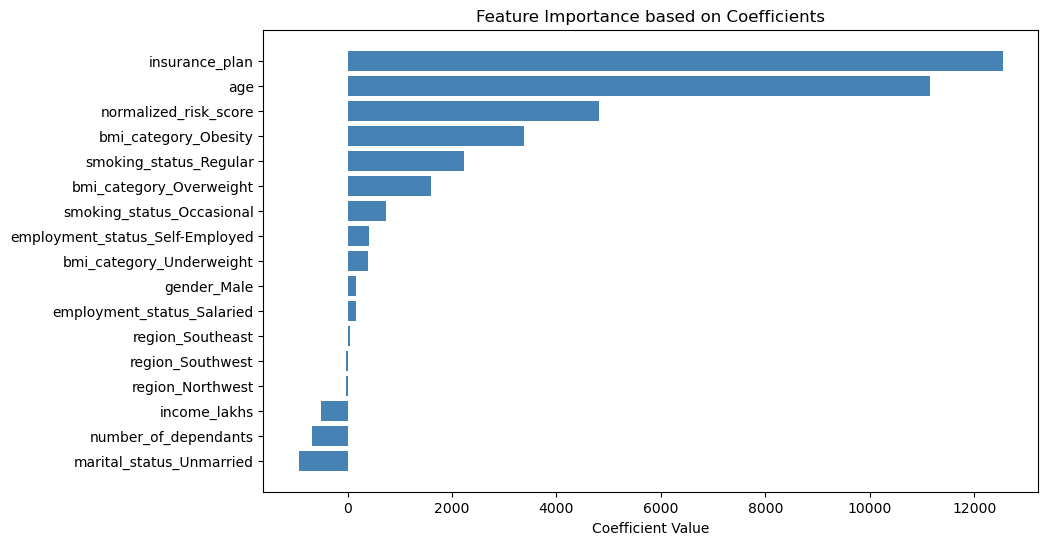

In [325]:
features_importance=Lr.coef_
coef_df=pd.DataFrame(features_importance,index=x_test.columns,columns=["Coefficients"])
coef_df=coef_df.sort_values(by="Coefficients", ascending=True)



plt.figure(figsize=(10,6))
plt.barh(coef_df.index, coef_df['Coefficients'],color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance based on Coefficients')
plt.show()


In [326]:
Lr.intercept_

4824.300272127079

In [327]:
model_ridge=Ridge()
model_ridge.fit(x_train,y_train)
test_score=model_ridge.score(x_test,y_test)
train_score=model_ridge.score(x_train,y_train)
print("Test Score:",test_score)
print("Train Score:",train_score)

Test Score: 0.9280541644640345
Train Score: 0.9282143198366275


In [286]:
model_lasso=Lasso()
model_lasso.fit(x_train,y_train)
test_score=model_lasso.score(x_test,y_test)
train_score=model_lasso.score(x_train,y_train)
print("Test Score:",test_score)
print("Train Score:",train_score)

Test Score: 0.9280870828363261
Train Score: 0.928211327505007


In [ ]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=10)
xgb_model.fit(x_train, y_train)
test_score=xgb_model.score(x_test,y_test)
train_score=xgb_model.score(x_train,y_train)
print("Test Score:",test_score)
print("Train Score:",train_score)

Test Score: 0.9809534549713135
Train Score: 0.9860964417457581


In [288]:
y_pred=xgb_model.predict(x_test)
mse_lr=mean_squared_error(y_test,y_pred)
rmse_lr=np.sqrt(mse_lr)
print(f"XGBoost Regression ==> MSE:,{mse_lr} RMSE: {rmse_lr}")

XGBoost Regression ==> MSE:,1367525.6922808294 RMSE: 1169.412541527082


In [300]:
from sklearn.model_selection import RandomizedSearchCV
model_xgb=XGBRegressor()
param_grid={
    'n_estimators':[20,40,50],
    'learning_rate':[0.01,0.1,0.2],
    'max_depth':[3,4,5],
   
}
random_search=RandomizedSearchCV(estimator=model_xgb,param_distributions=param_grid,n_iter=10,cv=3,scoring="r2",random_state=42,n_jobs=-1)
random_search.fit(x_train,y_train)
best_model=random_search.best_score_
print("Best Model:",best_model)

Best Model: 0.9809474547704061


In [301]:
best_model=random_search.best_estimator_

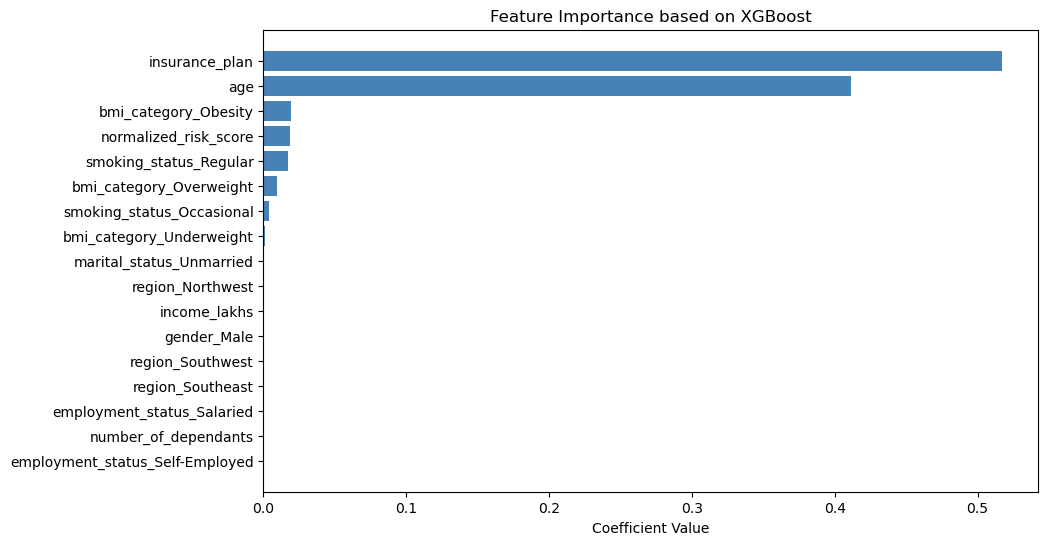

In [302]:
features_importance=best_model.feature_importances_
coef_df=pd.DataFrame(features_importance,index=x_test.columns,columns=["Coefficients"])
coef_df=coef_df.sort_values(by="Coefficients", ascending=True)



plt.figure(figsize=(10,6))
plt.barh(coef_df.index, coef_df['Coefficients'],color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance based on XGBoost')
plt.show()

### Error Analysis

In [303]:
y_pred=best_model.predict(x_test)
residuals=y_test-y_pred
residual_pct=residuals*100/y_test
result_df=pd.DataFrame(
    {
        "actual":y_test,
        "predicted":y_pred,
        "diff":residuals,
        "diff_pct":residual_pct
    }
)
result_df.head()

,actual,predicted,diff,diff_pct
3598,20554,20334.953125,219.046875,1.065714
35794,29647,29378.779297,268.220703,0.904714
43608,20560,20618.185547,-58.185547,-0.283004
42730,5018,7352.829590,-2334.829590,-46.529087
18936,8929,8203.291992,725.708008,8.127540


<Axes: xlabel='diff_pct', ylabel='Count'>

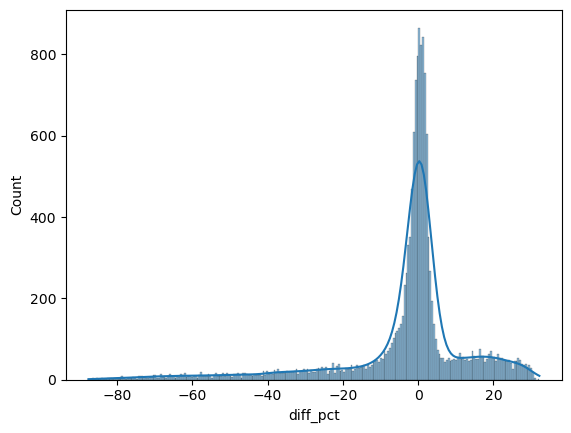

In [304]:
sns.histplot(result_df["diff_pct"],kde=True)

In [307]:
extreme_error_threshold=10
extreme_result_df=result_df[np.abs(result_df.diff_pct)>extreme_error_threshold]
extreme_result_df.shape

(4487, 4)

In [309]:
extreme_error_pct=extreme_result_df.shape[0]*100/result_df.shape[0]
extreme_error_pct

29.967274427302478

In [311]:
result_df[np.abs(result_df.diff_pct)>50].sort_values("diff_pct",ascending=False)

,actual,predicted,diff,diff_pct
16908,4699,7053.477539,-2354.477539,-50.105928
10107,4710,7073.240723,-2363.240723,-50.174962
13736,4371,6565.852051,-2194.852051,-50.213957
14798,4371,6565.852051,-2194.852051,-50.213957
32671,4656,6994.980957,-2338.980957,-50.235845
...,...,...,...,...
7988,3527,6565.852051,-3038.852051,-86.159684
18564,3523,6565.852051,-3042.852051,-86.371049
42342,3521,6565.852051,-3044.852051,-86.476911
48801,3516,6565.852051,-3049.852051,-86.742095


In [313]:
x_test.index

Index([ 3598, 35794, 43608, 42730, 18936, 45416, 20029,  4294, 39145,  3152,
       ...
        4554,  9086,  8767,   603, 25179,  5621,  6069, 21592, 49274, 27977],
      dtype='int64', length=14973)

In [312]:
extreme_result_df.index

Index([42730, 20029,  4294, 44419,  6707, 11728, 15740, 35065,  9654, 22679,
       ...
       36158, 30386, 21184, 45020,  8249,  8767, 25179, 21592, 49274, 27977],
      dtype='int64', length=4487)

In [315]:
extreme_erorr_df=x_test.loc[extreme_result_df.index]
extreme_erorr_df

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42730,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
20029,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0
4294,0.000000,0.2,0.020202,0.0,0.000000,1,0,0,1,1,0,1,0,0,0,0,0
44419,0.055556,0.0,0.242424,0.0,0.000000,0,0,0,0,1,0,0,1,0,0,0,0
6707,0.111111,0.2,0.070707,0.5,0.000000,1,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,0.018519,0.2,0.070707,0.0,0.000000,0,0,1,0,1,0,0,0,0,0,0,0
25179,0.129630,0.0,0.111111,0.0,0.000000,1,0,0,0,1,0,0,0,0,1,0,0
21592,0.055556,0.0,0.060606,0.5,0.000000,1,0,0,0,1,0,0,0,0,1,0,0
49274,0.055556,0.2,0.070707,0.0,0.000000,0,0,0,0,1,0,0,0,1,0,0,0


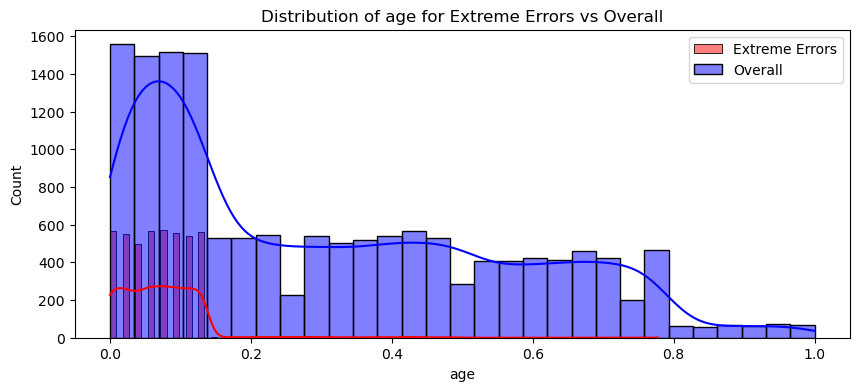

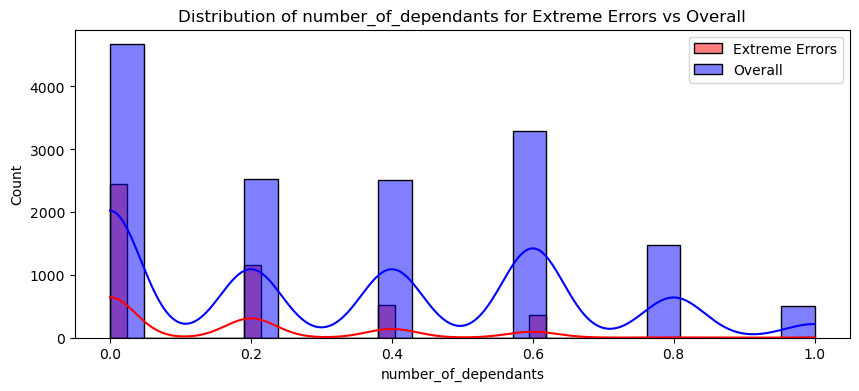

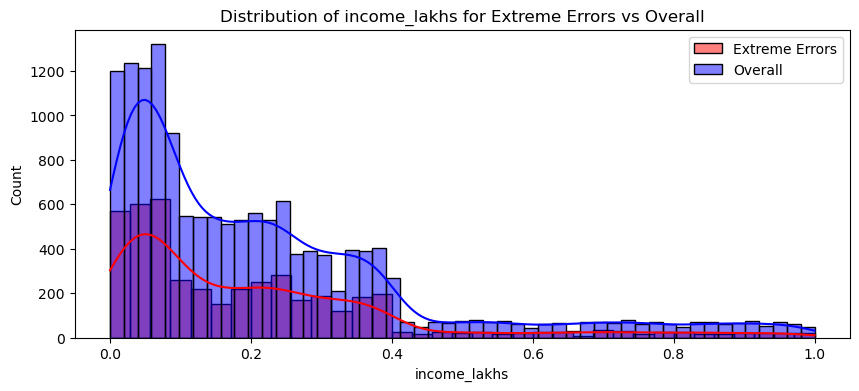

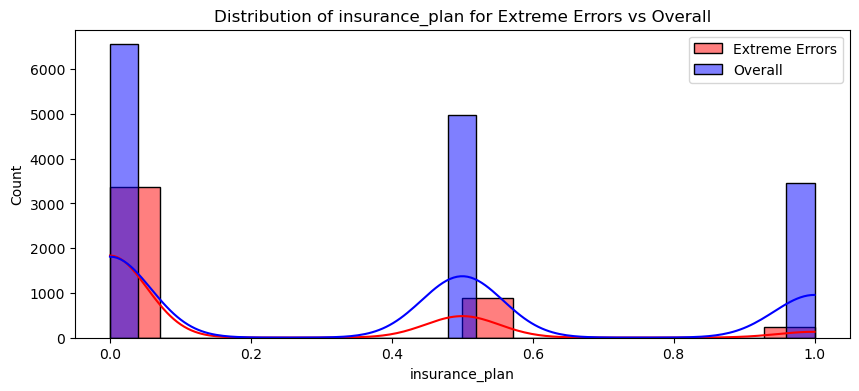

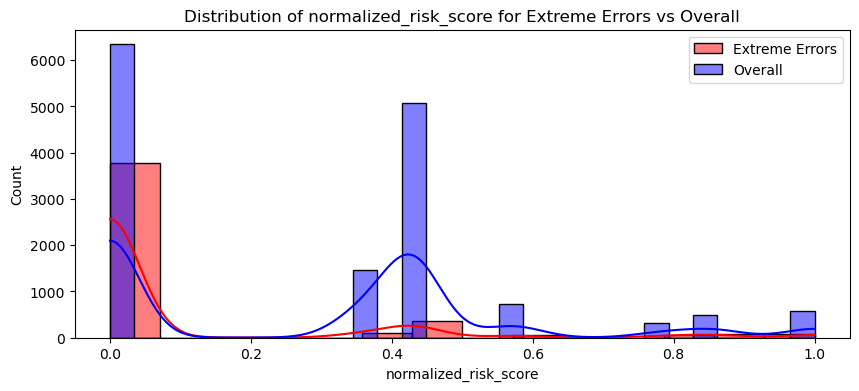

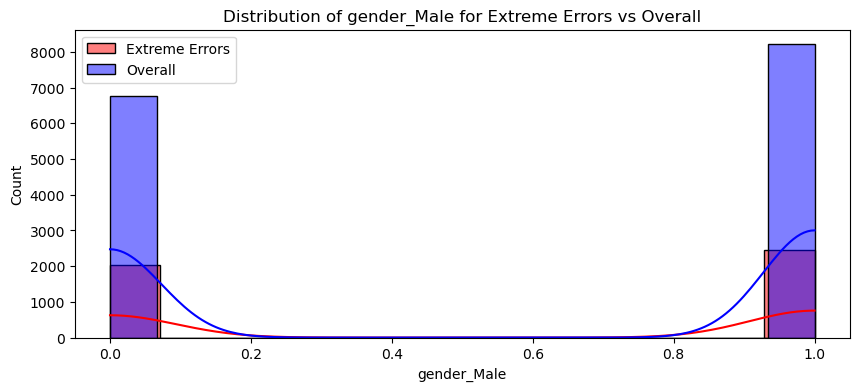

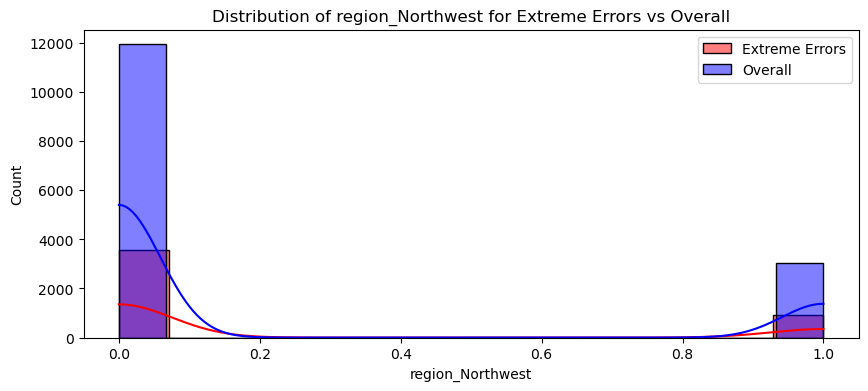

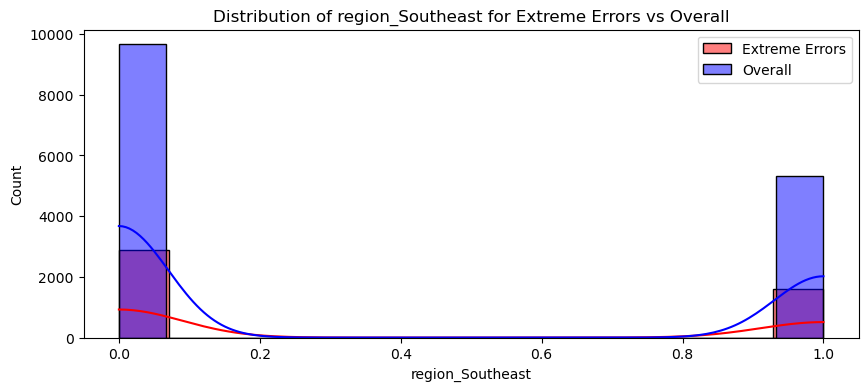

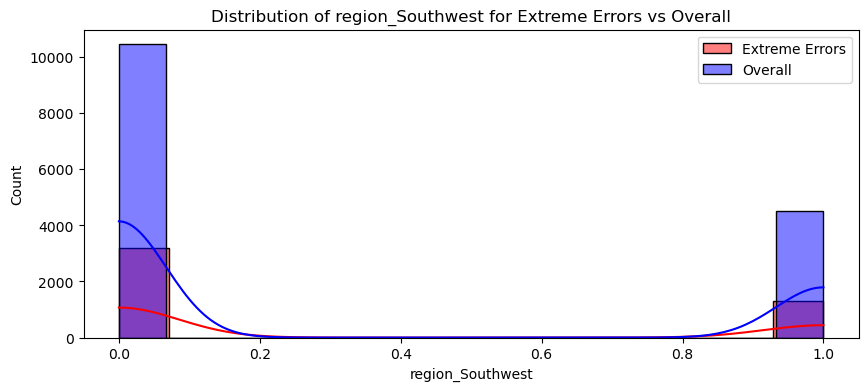

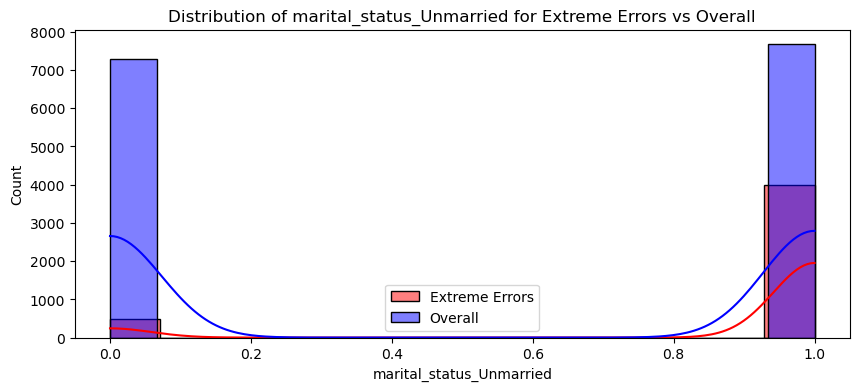

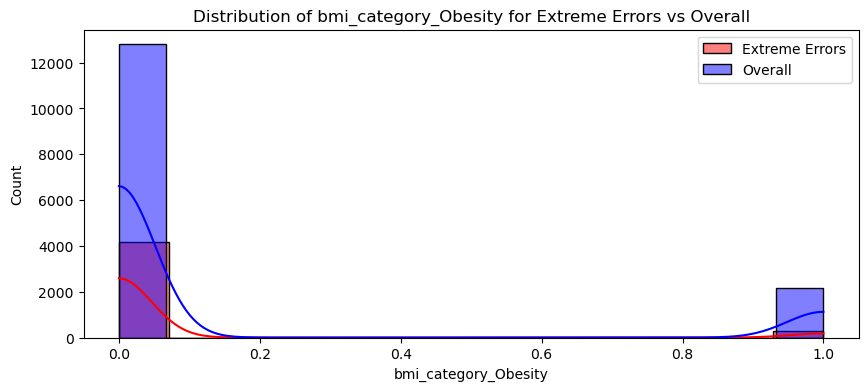

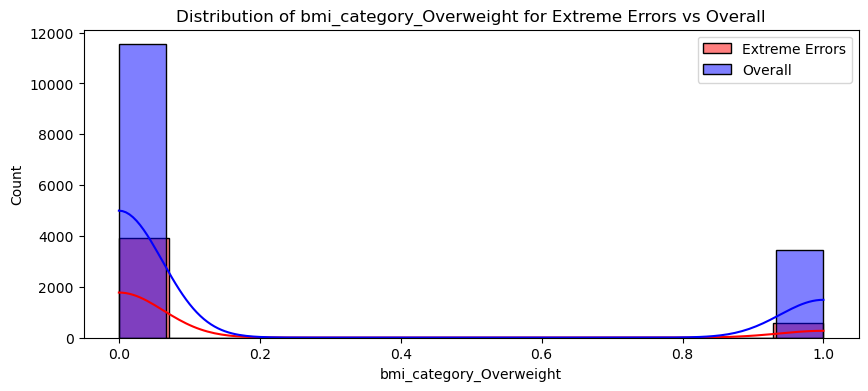

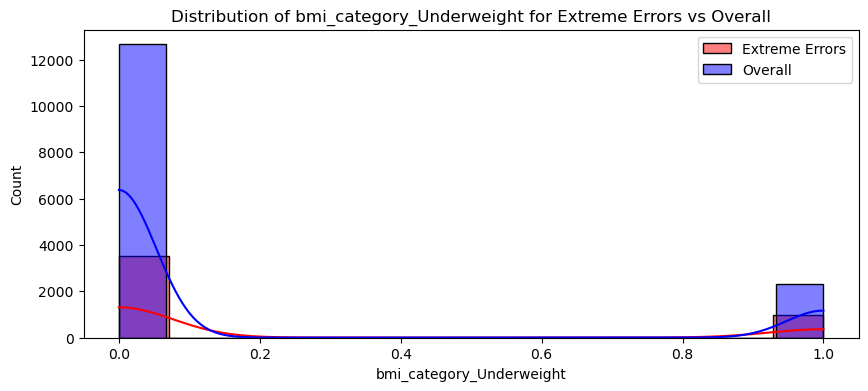

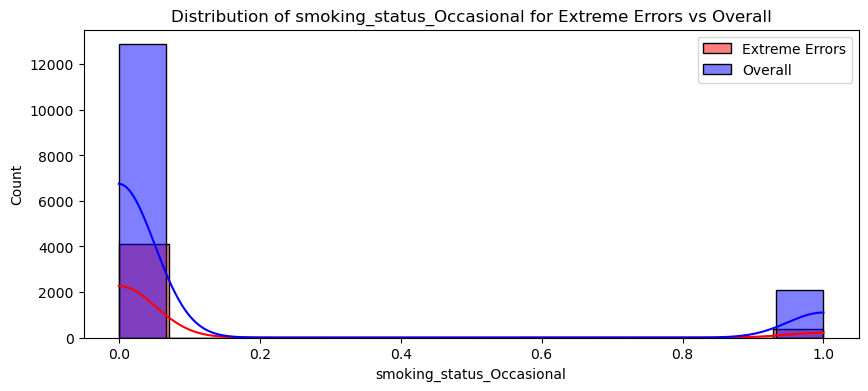

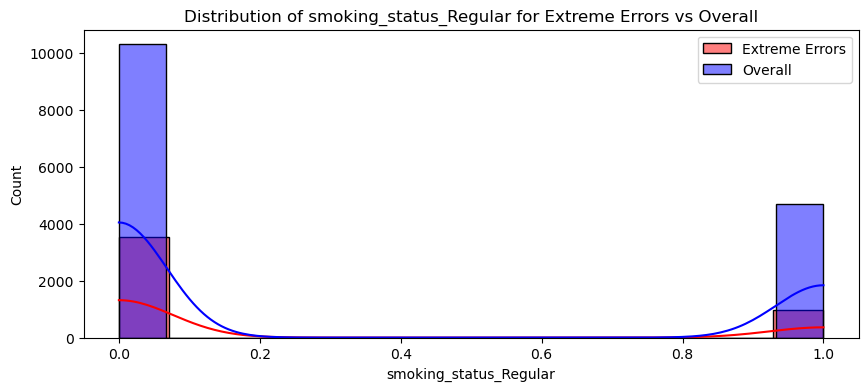

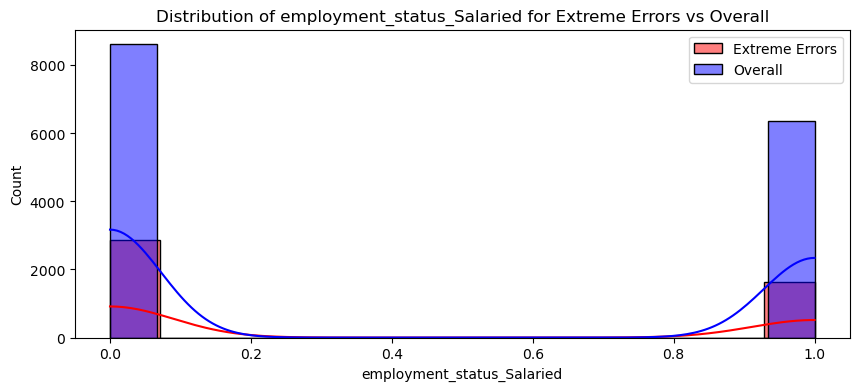

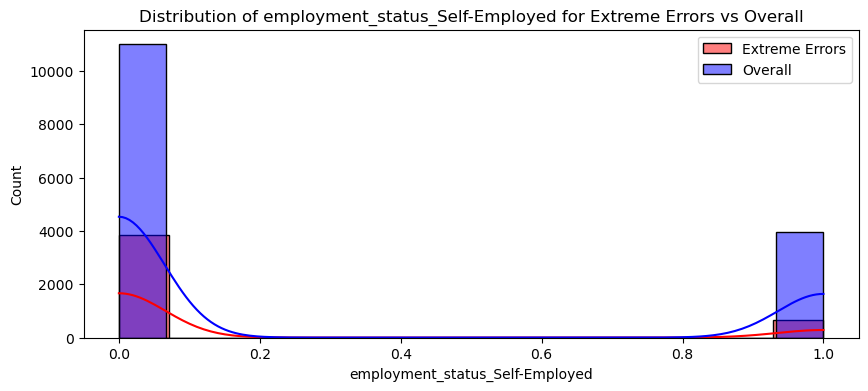

In [334]:
for feature in x_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_erorr_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(x_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

In [337]:
extreme_erorr_df["income_level"]=-1

<Axes: xlabel='age', ylabel='Count'>

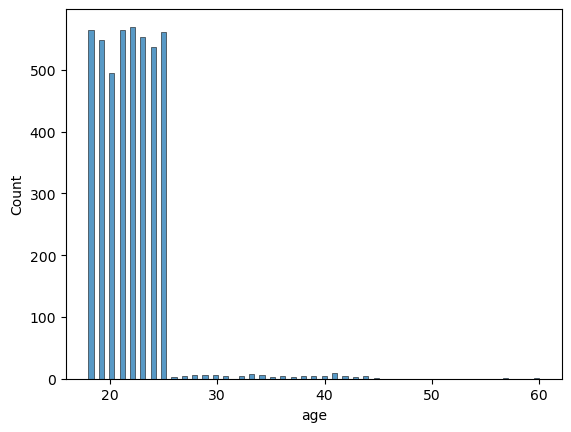

In [339]:
df_reversed=pd.DataFrame()

df_reversed[cols_to_scale]=scaler.inverse_transform(extreme_erorr_df[cols_to_scale])
sns.histplot(df_reversed.age)